In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
#!git reset --hard origin/master
#!git pull

In [2]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/](https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/)

This spreadsheet consists of three worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, &ldquo;Prices&rdquo;, and a series of different years of food &ldquo;Expenditures&rdquo;.

Each worksheet has the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should
have one column for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Ugandan example that I wish to work
through.



In [3]:
Malawi_Data = '1-RiJTwSi5CfL4sNxDyOsyV0SkculNdwUbFKi1zfgWWM'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [4]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

x = read_sheets(Malawi_Data,sheet='Expenditures')
x.columns.name = 'j'
                 
# Change 'Uganda' to key of your own sheet in Sheets, above
d = read_sheets(Malawi_Data,sheet="HH Characteristics")
d.columns.name = 'k'

# x may have duplicate columns
x = x.groupby('j',axis=1).sum()
x = x.replace(0,np.nan) # Replace zeros with missing
x = x.set_index(['i','t','m'])
x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Take logs of expenditures; call this y
y = np.log(x.replace(0,np.nan).dropna(how='all'))

d.set_index(['i','t','m'],inplace=True)

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


This gives a dataframe of household characteristics $d$ with a simple structure.



Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [5]:
d=d.xs(2010,level='t',drop_level=False).sample(n=5000, replace=False)


In [6]:
d.index

MultiIndex([(302083960158, 2010, 'Malawi'),
            (103064170014, 2010, 'Malawi'),
            (308064830078, 2010, 'Malawi'),
            (105017090050, 2010, 'Malawi'),
            (312015160089, 2010, 'Malawi'),
            (313012460095, 2010, 'Malawi'),
            (301025400094, 2010, 'Malawi'),
            (210316430077, 2010, 'Malawi'),
            (203057170039, 2010, 'Malawi'),
            (102030130017, 2010, 'Malawi'),
            ...
            (311050910083, 2010, 'Malawi'),
            (302220770169, 2010, 'Malawi'),
            (313016710067, 2010, 'Malawi'),
            (315362570066, 2010, 'Malawi'),
            (207016590120, 2010, 'Malawi'),
            (309014090099, 2010, 'Malawi'),
            (204020720023, 2010, 'Malawi'),
            (310073350029, 2010, 'Malawi'),
            (202036560037, 2010, 'Malawi'),
            (202052070015, 2010, 'Malawi')],
           names=['i', 't', 'm'], length=5000)

In [7]:
#y=y.xs(2004,level='t',drop_level=False)

There may be some goods that very few people consume&#x2014;too few to estimate demand reliably.   We have code to deal with this.  You can play with the `min_obs` parameter&#x2014;the larger it is, the more foods will be dropped.



In [8]:
#from cfe.estimation import drop_columns_wo_covariance

#y = drop_columns_wo_covariance(y,min_obs=30)

Now, we want the $d$ and $y$ dataframes to have rows that line up:



In [9]:
#use = y.index.intersection(d.index)
#y = y.loc[use,:]
#d = d.loc[use,:]

## Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
So, a first step is to turn our dataframe for `y` into a series, so we can put it on the left-hand side of this regression.  Then we need to make our dataframe $d$ conform:



In [10]:
y = y.stack()
d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

In [11]:
y.head()

i            t     m       j          
10101002025  2004  Malawi  Avocado        2.302585
                           Beef           5.075174
                           Cooking oil    3.401197
                           Salt           1.609438
                           Tomato         1.609438
dtype: float64

In [12]:
d.head()

i             t     m       k      
302083960158  2010  Malawi  M 0-3      1
                            M 4-8      0
                            M 9-13     0
                            M 14-18    0
                            M 19-30    1
dtype: int64

### Basic Estimation



Just one line to set up the regression:



In [13]:
from cfe import Regression

result = Regression(y=y,d=d)

Missing dependencies for OracleDemands.


And then one line to predict expenditures and estimate most of the things we need:



In [14]:
result.predicted_expenditures()

i             t     m       j                                        
101012040071  2010  Malawi  Banana                                        192.250526
                            Bean, brown                                   251.665886
                            Bean, white                                   316.340828
                            Beef                                         1145.206884
                            Biscuits                                      159.555327
                                                                            ...     
315556140388  2010  Malawi  Tanaposi rape                                  47.365656
                            Tea                                            23.452581
                            Tomato                                         77.370822
                            White sweet potato                             81.279176
                            Yeast, baking powder, bicarbonate of soda      13.20

Now we can compare predicted log expenditures with actual:



<IPython.core.display.Javascript object>


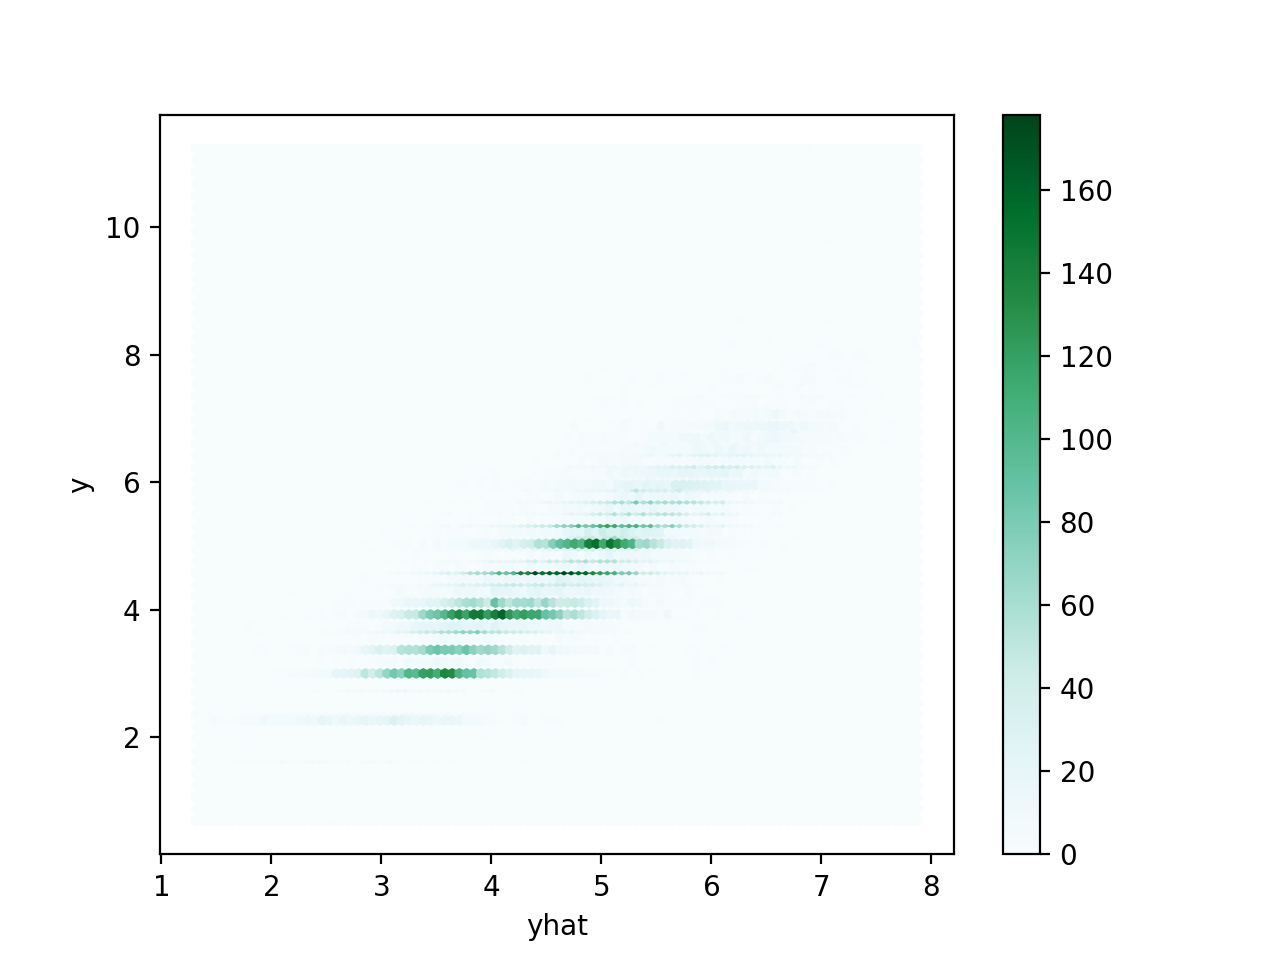

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [15]:
%matplotlib notebook
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.hexbin(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



### Parameters



#### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.



In [16]:
result.get_beta().sort_values()

j
Maize ufa mgaiwa (normal flour)              0.103693
Margarine                                    0.115971
Maize ufa refined (fine flour)               0.138519
Chicken                                      0.187190
Sugar                                        0.199062
Bean, brown                                  0.207000
Bean, white                                  0.217350
Orange sweet potato                          0.228565
Salt                                         0.231211
White sweet potato                           0.232698
Cabbage                                      0.253031
Cassava tubers                               0.257300
Buns, scones                                 0.265287
Tea                                          0.275034
Beef                                         0.276719
Mandazi, doughnut (vendor)                   0.282657
Chips (vendor)                               0.284903
Eggs                                         0.289191
Chinese cabbage           

Here we use a plot to visualize, with confidence intervals.



<IPython.core.display.Javascript object>


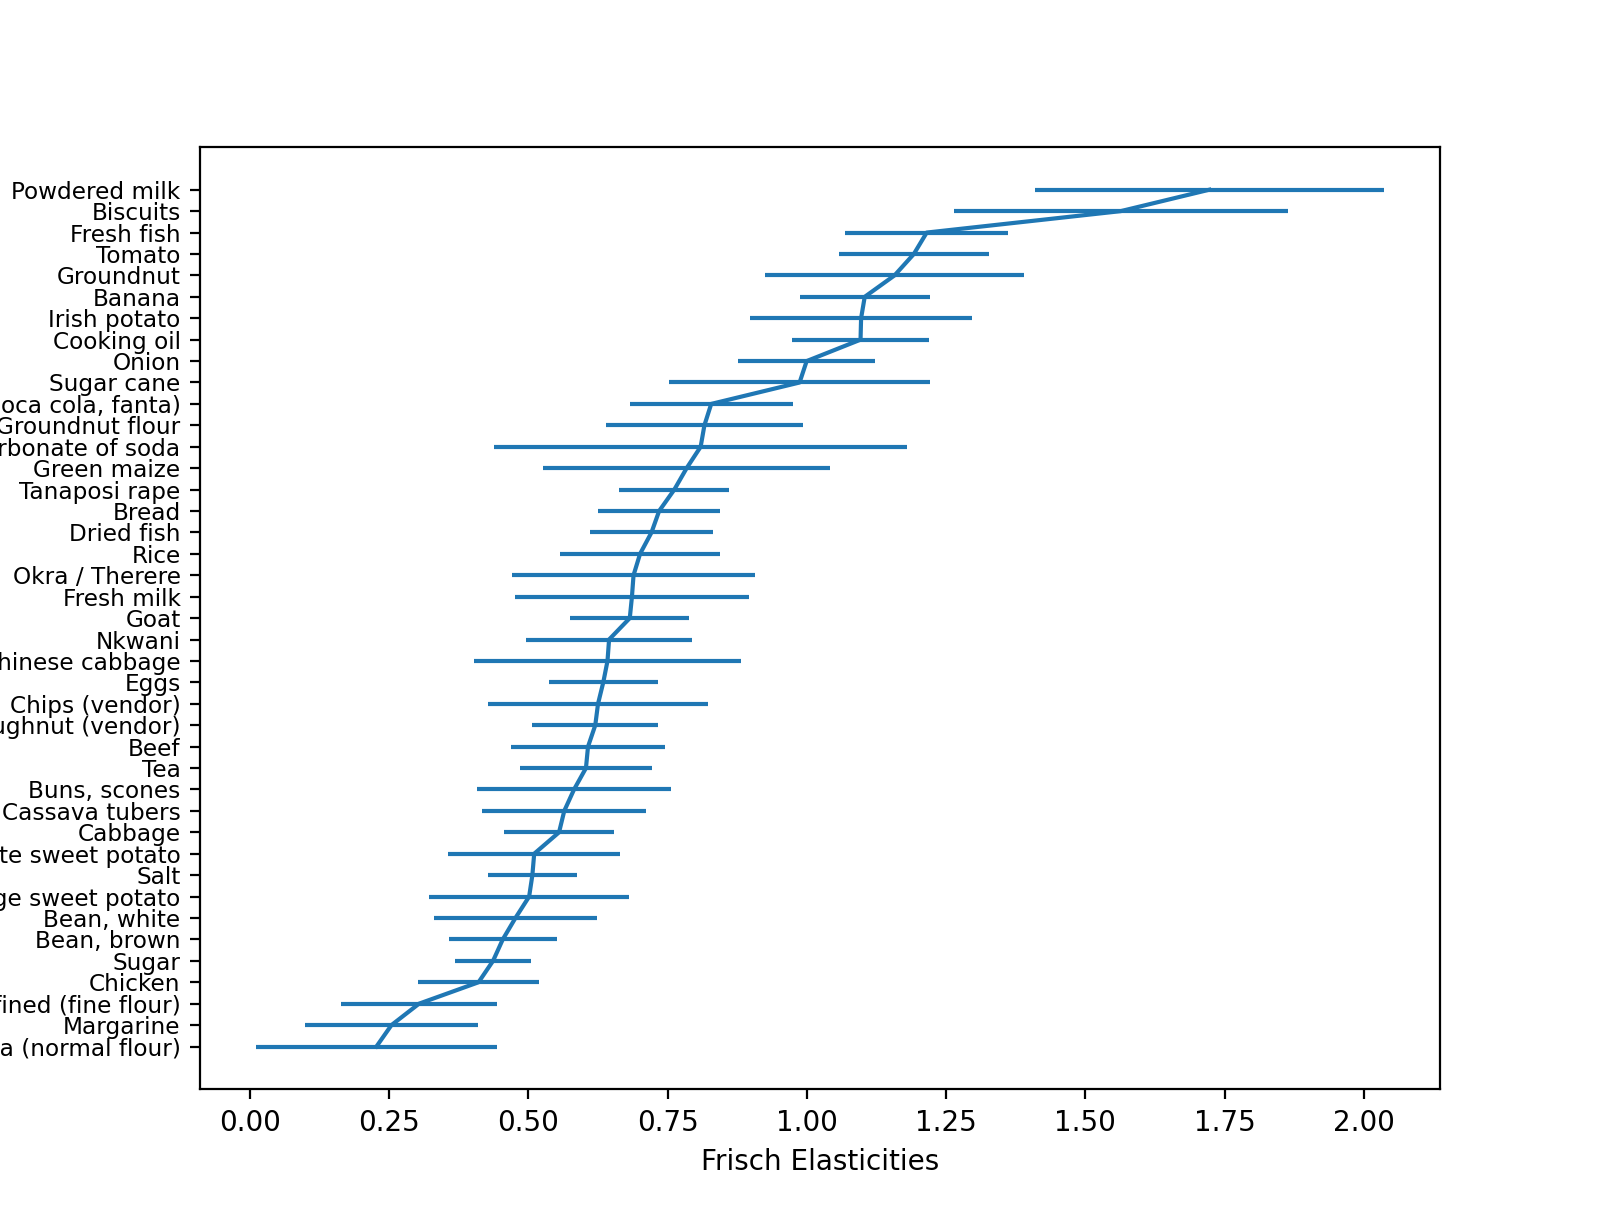

<IPython.core.display.Javascript object>


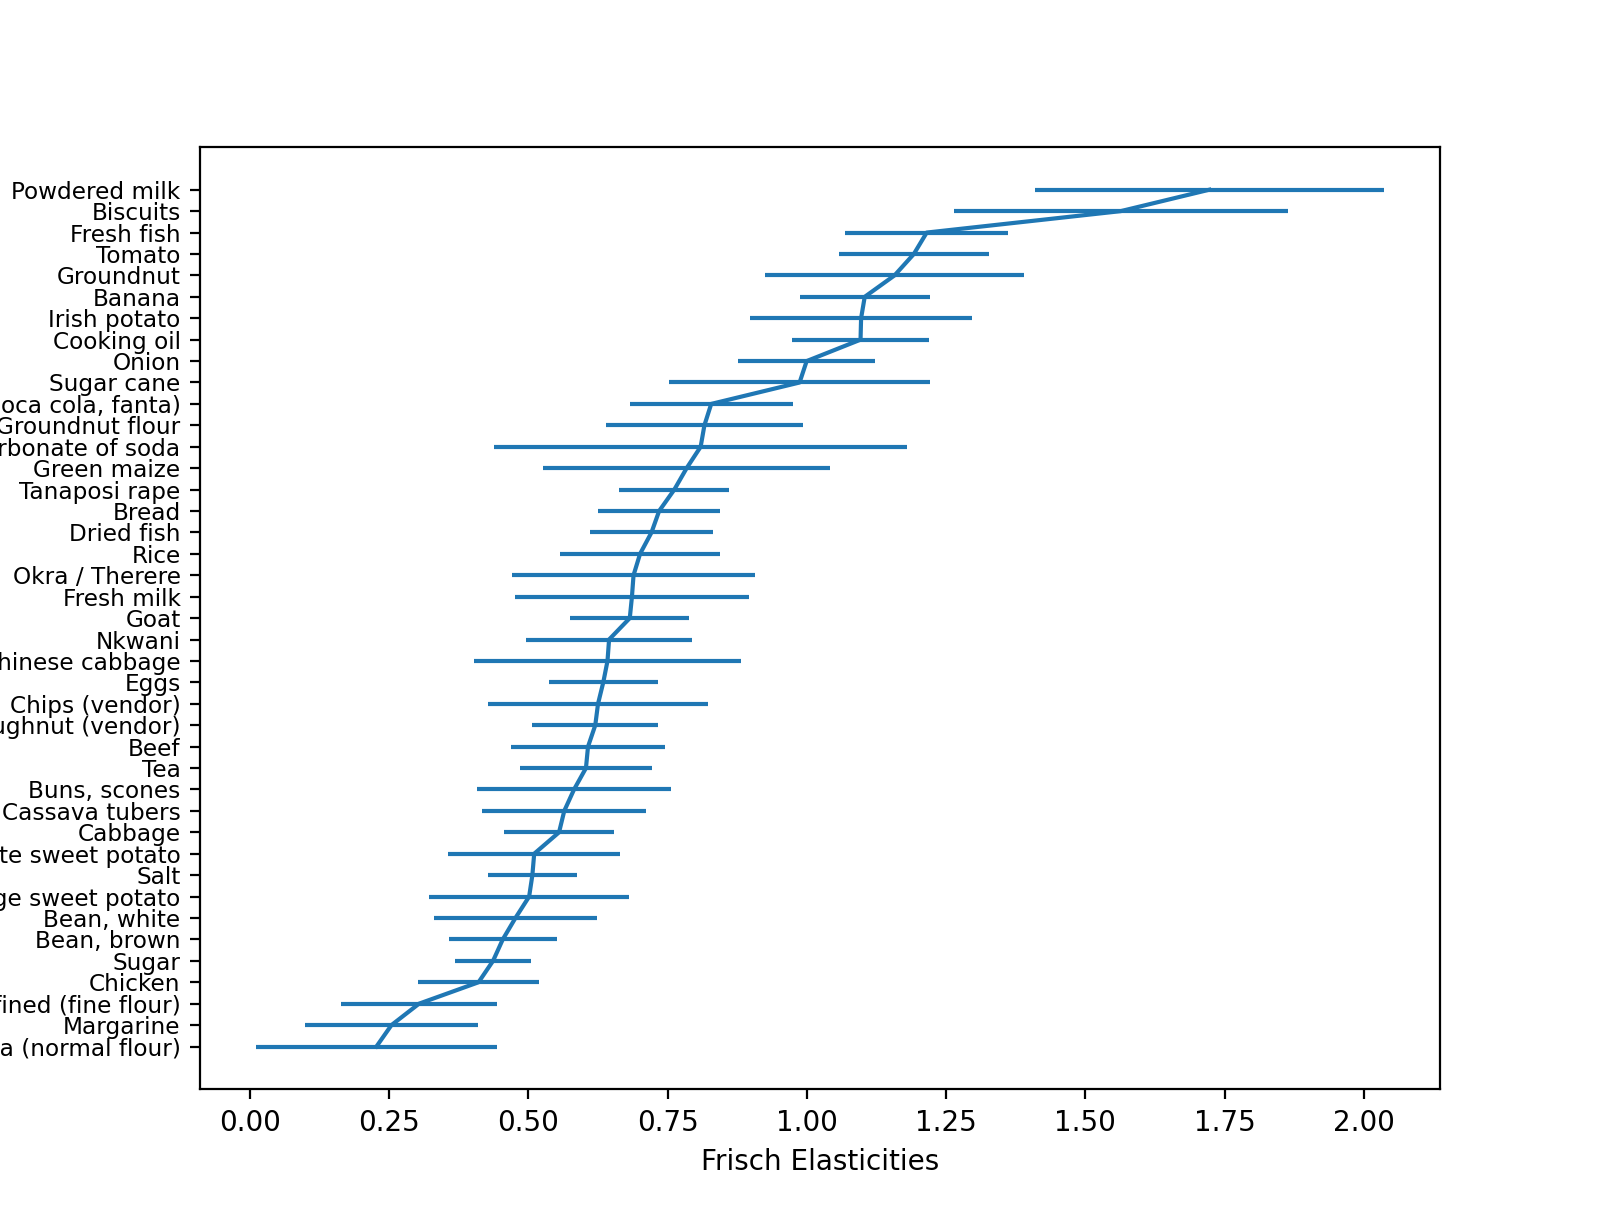

In [17]:
result.graph_beta()

#### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [18]:
result.gamma

k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Constant
j,,,,,,,,,,,,,,,
Banana,-0.041928,-0.016972,0.004909,0.110081,0.152392,0.358316,0.158059,-0.150418,-0.050055,0.102892,0.079984,0.302423,0.224437,-0.009023,-0.581615
"Bean, brown",0.014229,0.089185,0.083484,0.081066,0.124029,0.126299,-0.016121,0.004395,0.060578,0.073071,0.081190,0.111236,0.187094,0.285388,-0.459179
"Bean, white",-0.039932,-0.017113,0.068869,0.052104,0.133788,0.150108,0.071069,-0.044526,0.055120,0.052761,0.064439,0.194187,0.242142,0.245888,-0.484507
Beef,-0.110414,0.014042,0.092050,0.059978,0.181943,0.188074,0.080087,-0.123038,0.005982,0.047160,0.115128,0.250819,0.245814,0.217267,-0.701729
Biscuits,-0.401111,-0.198234,0.133564,-0.070161,0.092127,0.200079,-0.102272,-0.190988,-0.061538,0.032827,-0.043676,0.220001,0.299312,0.173809,-0.204328
Bread,-0.135620,-0.067011,0.062982,0.007613,0.131424,0.217808,0.161346,-0.014950,-0.016420,0.058151,0.049160,0.172909,0.214330,0.126632,-0.497683
"Buns, scones",-0.015805,0.069399,0.131050,0.169503,0.155717,0.192890,0.173819,0.114584,0.104808,0.088696,0.160758,0.232048,0.106157,0.096483,-0.600957
Cabbage,0.026240,0.013479,0.076999,0.079933,0.146565,0.204249,0.125003,0.044625,0.027396,0.101620,0.078200,0.150750,0.051269,0.055345,-0.467551
Cassava tubers,-0.036080,0.037822,0.060435,0.170686,0.157709,0.225209,0.103706,0.004853,0.042622,0.095705,0.095026,0.202682,0.234055,0.279360,-0.570391


### Saving Result



You can save the estimated result, using something like



In [19]:
result.to_pickle('my_estimates.pickle')

You can subsequently load this using



In [20]:
import cfe
result = cfe.regression.read_pickle('my_estimates.pickle')